#### Mnist example for dist-keras

This notebook is the modified version of 
https://github.com/cerndb/dist-keras/blob/master/examples/mnist.ipynb

The original author is 
Joeri Hermans (Technical Student, IT-DB-SAS, CERN)<br>
Departement of Knowledge Engineering<br>
Maastricht University, The Netherlands<br>

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <https://www.gnu.org/licenses/>.

In [1]:
%matplotlib inline

import numpy as np

import seaborn as sns

from keras.optimizers import *
from keras.models import Sequential
from keras.layers.core import *
from keras.layers.convolutional import *

from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import *

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from distkeras.trainers import *
from distkeras.predictors import *
from distkeras.transformers import *
from distkeras.evaluators import *
from distkeras.utils import *

Using TensorFlow backend.


In [2]:
# Modify these variables according to your needs.
application_name = "Distributed Keras MNIST Notebook"
using_spark_2 = True
local = True
path_train = "data/mnist_train.csv"
path_test = "data/mnist_test.csv"
if local:
    # Tell master to use local resources.
    master = "local[*]"
    num_processes = 3
    num_executors = 1
else:
    # Tell master to use YARN.
    master = "yarn-client"
    num_executors = 20
    num_processes = 1

In [3]:
num_workers = num_executors * num_processes

print("Number of desired executors: ", num_executors)
print("Number of desired processes / executor: ", num_processes)
print("Total number of workers: ", num_workers)

Number of desired executors:  1
Number of desired processes / executor:  3
Total number of workers:  3


In [4]:
import os

# Use the DataBricks CSV reader, this has some nice functionality regarding invalid values.
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-csv_2.10:1.4.0 pyspark-shell'

In [5]:
conf = SparkConf()
conf.set("spark.app.name", application_name)
conf.set("spark.master", master)
conf.set("spark.executor.cores", num_processes)
conf.set("spark.executor.instances", num_executors)
conf.set("spark.executor.memory", "4g")
conf.set("spark.locality.wait", "0")
conf.set("spark.serializer", "org.apache.spark.serializer.KryoSerializer");

# Check if the user is running Spark 2.0 +
if using_spark_2:
    sc = SparkSession.builder.config(conf=conf) \
            .appName(application_name) \
            .getOrCreate()
else:
    # Create the Spark context.
    sc = SparkContext(conf=conf)
    # Add the missing imports
    from pyspark import SQLContext
    sqlContext = SQLContext(sc)

In [6]:
# Check if we are using Spark 2.0
if using_spark_2:
    reader = sc
else:
    reader = sqlContext
# Read the training dataset.
raw_dataset_train = reader.read.format('com.databricks.spark.csv') \
                          .options(header='true', inferSchema='true') \
                          .load(path_train)
# Read the testing dataset.
raw_dataset_test = reader.read.format('com.databricks.spark.csv') \
                         .options(header='true', inferSchema='true') \
                         .load(path_test)

In [7]:
# First, we would like to extract the desired features from the raw dataset.
# We do this by constructing a list with all desired columns.
# This is identical for the test set.
#print(raw_dataset_train.columns)
features = raw_dataset_train.columns
features.remove('label')


In [8]:
# Next, we use Spark's VectorAssembler to "assemble" (create) a vector of all desired features.
# http://spark.apache.org/docs/latest/ml-features.html#vectorassembler
vector_assembler = VectorAssembler(inputCols=features, outputCol="features")
# This transformer will take all columns specified in features, and create an additional column "features" which will contain all the desired features aggregated into a single vector.
dataset_train = vector_assembler.transform(raw_dataset_train)
dataset_test = vector_assembler.transform(raw_dataset_test)

In [9]:
# Define the number of output classes.
nb_classes = 10
encoder = OneHotTransformer(nb_classes, input_col="label", output_col="label_encoded")
dataset_train = encoder.transform(dataset_train)
dataset_test = encoder.transform(dataset_test)

In [10]:
def show_instances(column):
    global dataset

    num_instances = 6 # Number of instances you would like to draw.
    x_dimension   = 3 # Number of images to draw on the x-axis.
    y_dimension   = 2 # Number of images to draw on the y-axis.

    # Fetch 3 different instance from the dataset.
    instances = dataset_train.select(column).take(num_instances)
    # Process the instances.
    for i in range(0, num_instances):
        instance = instances[i]
        instance = instance[column].toArray().reshape((28, 28))
        instances[i] = instance

    # Draw the sampled instances.
    fig, axn = plt.subplots(y_dimension, x_dimension, sharex=True, sharey=True)
    num_axn = len(axn.flat)
    for i in range(0, num_axn):
        ax = axn.flat[i]
        h = sns.heatmap(instances[i], ax=ax)
        h.set_yticks([])
        h.set_xticks([])

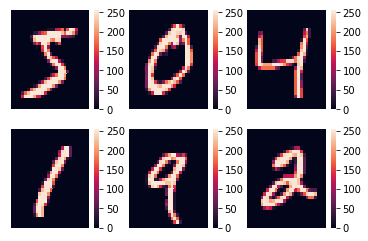

In [11]:
show_instances("features")

In [12]:
# Clear the dataset in the case you ran this cell before.
dataset_train = dataset_train.select("features", "label", "label_encoded")
dataset_test = dataset_test.select("features", "label", "label_encoded")
# Allocate a MinMaxTransformer using Distributed Keras.
# o_min -> original_minimum
# n_min -> new_minimum
transformer = MinMaxTransformer(n_min=0.0, n_max=1.0, \
                                o_min=0.0, o_max=250.0, \
                                input_col="features", \
                                output_col="features_normalized")
# Transform the dataset.
dataset_train = transformer.transform(dataset_train)
dataset_test = transformer.transform(dataset_test)

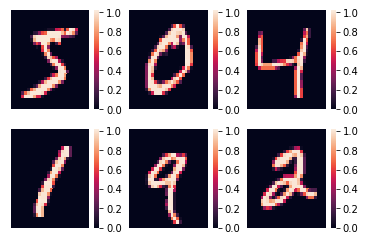

In [13]:
show_instances("features_normalized")

In [14]:
reshape_transformer = ReshapeTransformer("features_normalized", "matrix", (28, 28, 1))
dataset_train = reshape_transformer.transform(dataset_train)
dataset_test = reshape_transformer.transform(dataset_test)

In [15]:
mlp = Sequential()
mlp.add(Dense(1000, input_shape=(784,)))
mlp.add(Activation('relu'))
mlp.add(Dense(250))
mlp.add(Activation('relu'))
mlp.add(Dense(10))
mlp.add(Activation('softmax'))

In [16]:
mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1000)              785000    
_________________________________________________________________
activation_1 (Activation)    (None, 1000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 250)               250250    
_________________________________________________________________
activation_2 (Activation)    (None, 250)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2510      
_________________________________________________________________
activation_3 (Activation)    (None, 10)                0         
Total params: 1,037,760
Trainable params: 1,037,760
Non-trainable params: 0
_________________________________________________________________


In [17]:
optimizer_mlp = 'adam'
loss_mlp = 'categorical_crossentropy'

In [18]:
# Taken from Keras MNIST example.

# Declare model parameters.
img_rows, img_cols = 28, 28
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)
input_shape = (img_rows, img_cols, 1)

# Construct the model.
convnet = Sequential()
convnet.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1],
                          border_mode='valid',
                          input_shape=input_shape))
convnet.add(Activation('relu'))
convnet.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1]))
convnet.add(Activation('relu'))
convnet.add(MaxPooling2D(pool_size=pool_size))

convnet.add(Flatten())
convnet.add(Dense(225))
convnet.add(Activation('relu'))
convnet.add(Dense(nb_classes))
convnet.add(Activation('softmax'))

/home/vs/sparktest/env/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(28, 28, 1..., padding="valid")`
/home/vs/sparktest/env/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3))`


In [19]:
convnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_4 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
activation_5 (Activation)    (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 225)               1037025   
__________

In [20]:
optimizer_convnet = 'adam'
loss_convnet = 'categorical_crossentropy'

In [21]:
def evaluate_accuracy(model, test_set, features="features_normalized_dense"):
    evaluator = AccuracyEvaluator(prediction_col="prediction_index", label_col="label")
    predictor = ModelPredictor(keras_model=model, features_col=features)
    transformer = LabelIndexTransformer(output_dim=nb_classes)
    test_set = test_set.select(features, "label")
    test_set = predictor.predict(test_set)
    test_set = transformer.transform(test_set)
    score = evaluator.evaluate(test_set)
    
    return score

In [22]:
dataset_train.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: long (nullable = true)
 |-- label_encoded: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- features_normalized: vector (nullable = true)
 |-- matrix: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: array (containsNull = true)
 |    |    |    |-- element: double (containsNull = true)



In [23]:
dataset_train = dataset_train.select("features_normalized", "matrix","label", "label_encoded")
dataset_test = dataset_test.select("features_normalized", "matrix","label", "label_encoded")

In [24]:
dense_transformer = DenseTransformer(input_col="features_normalized", output_col="features_normalized_dense")
dataset_train = dense_transformer.transform(dataset_train)
dataset_test = dense_transformer.transform(dataset_test)
dataset_train.repartition(num_workers)
dataset_test.repartition(num_workers)

DataFrame[features_normalized: vector, matrix: array<array<array<double>>>, label: bigint, label_encoded: array<double>, features_normalized_dense: vector]

In [25]:
# Assing the training and test set.
training_set = dataset_train.repartition(num_workers)
test_set = dataset_test.repartition(num_workers)
# Cache them.
training_set.cache()
test_set.cache()

DataFrame[features_normalized: vector, matrix: array<array<array<double>>>, label: bigint, label_encoded: array<double>, features_normalized_dense: vector]

In [26]:
print(training_set.count())

60000


In [27]:
trainer = DOWNPOUR(keras_model=mlp, worker_optimizer=optimizer_mlp, loss=loss_mlp, num_workers=num_workers,
                   batch_size=4, communication_window=5, num_epoch=1,
                   features_col="features_normalized_dense", label_col="label_encoded")
trained_model = trainer.train(training_set)

In [28]:
print("Training time: " + str(trainer.get_training_time()))
print("Accuracy: " + str(evaluate_accuracy(trained_model, test_set)))

Training time: 682.1345794200897
Accuracy: 0.9602


In [29]:
trainer.parameter_server.num_updates

3000

In [30]:
trainer = ADAG(keras_model=mlp, worker_optimizer=optimizer_mlp, loss=loss_mlp, num_workers=num_workers,
               batch_size=4, communication_window=15, num_epoch=1,
               features_col="features_normalized_dense", label_col="label_encoded")
trained_model = trainer.train(training_set)

In [ ]:
print("Training time: " + str(trainer.get_training_time()))
print("Accuracy: " + str(evaluate_accuracy(trained_model, test_set)))

Training time: 719.9144747257233
Accuracy: 0.9658


In [35]:
trainer.parameter_server.num_updates

427

In [ ]:
trainer = AEASGD(keras_model=mlp, worker_optimizer=optimizer_mlp, loss=loss_mlp, num_workers=num_workers,
                 batch_size=4, communication_window=35, num_epoch=1, features_col="features_normalized_dense",
                 label_col="label_encoded")
trained_model = trainer.train(training_set)

In [ ]:
print("Training time: " + str(trainer.get_training_time()))
print("Accuracy: " + str(evaluate_accuracy(trained_model, test_set)))

Training time: 426.63105845451355
Accuracy: 0.966


In [ ]:
trainer.parameter_server.num_updates

427

In [ ]:
trainer = DOWNPOUR(keras_model=convnet, worker_optimizer=optimizer_convnet, loss=loss_convnet,
                   num_workers=num_workers, batch_size=4, communication_window=5,
                   num_epoch=1, features_col="matrix", label_col="label_encoded")
trainer.set_parallelism_factor(1)
trained_model = trainer.train(training_set)

In [ ]:
print("Training time: " + str(trainer.get_training_time()))
print("Accuracy: " + str(evaluate_accuracy(trained_model, test_set, "matrix")))

Training time: 118.13034582138062
Accuracy: 0.9584


In [ ]:
trainer.parameter_server.num_updates

277

In [ ]:
trainer = ADAG(keras_model=convnet, worker_optimizer=optimizer_convnet, loss=loss_convnet,
               num_workers=num_workers, batch_size=15, communication_window=5, num_epoch=1,
               features_col="matrix", label_col="label_encoded")
trainer.set_parallelism_factor(1)
trained_model = trainer.train(training_set)

In [ ]:
print("Training time: " + str(trainer.get_training_time()))
print("Accuracy: " + str(evaluate_accuracy(trained_model, test_set, "matrix")))

Training time: 317.82619738578796
Accuracy: 0.9839


In [ ]:
trainer.parameter_server.num_updates

799

In [ ]:
trainer = AEASGD(keras_model=convnet, worker_optimizer=optimizer_convnet, loss=loss_convnet, 
                 num_workers=num_workers, batch_size=35, communication_window=32, num_epoch=1,
                 features_col="matrix", label_col="label_encoded")
trained_model = trainer.train(training_set)

In [ ]:
print("Training time: " + str(trainer.get_training_time()))
print("Accuracy: " + str(evaluate_accuracy(trained_model, test_set, "matrix")))

Training time: 246.6541771888733
Accuracy: 0.9803


In [ ]:
trainer.parameter_server.num_updates

52